In [1]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import random
import itertools
import math
import random
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive=drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Access to the dataset
data = pd.read_csv('/content/drive/MyDrive/T2_MLNS/MLNS_Project/PS_20174392719_1491204439457_log.csv')

# Columns
# step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
# type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
# amount -amount of the transaction in local currency.
# nameOrig - customer who started the transaction
# oldbalanceOrg - initial balance before the transaction
# newbalanceOrig - new balance after the transaction
# nameDest - customer who is the recipient of the transaction
# oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
# newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
# isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
# isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [38]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [39]:
print('All types: ',list(data['type'].drop_duplicates().values))

All types:  ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']


In [40]:
print('isFraud type', list(data[data.isFraud==1]['type'].drop_duplicates().values))
print('isFlaggedFraud type', list(data[data.isFlaggedFraud==1]['type'].drop_duplicates().values))
print('All transactions ', len(data))
print('isFraud transactions ', len(data[data.isFraud==1]))
print('- isFraud-TRANSFER transactions ', len(data[(data.isFraud==1)&(data['type']=='TRANSFER')]))
print('- isFraud-CASH_OUT transactions ', len(data[(data.isFraud==1)&(data['type']=='CASH_OUT')]))
print('isFlaggedFraud transactions ', len(data[data.isFlaggedFraud==1]))
# with isFlaggedFraud number is only 16, we decide to ignore those values

isFraud type ['TRANSFER', 'CASH_OUT']
isFlaggedFraud type ['TRANSFER']
All transactions  6362620
isFraud transactions  8213
- isFraud-TRANSFER transactions  4097
- isFraud-CASH_OUT transactions  4116
isFlaggedFraud transactions  16


In [4]:
# We only care about TRANSFER and CASH_OUT, because these are the two types where frauds happen
df_select = data.loc[(data['type']=='TRANSFER')|(data['type']=='CASH_OUT')]

# All transaction starter and transaction receiver
list_of_senders = list(df_select['nameOrig'])
list_of_dest = list(df_select['nameDest'])

# fraud transaction 
dd_fraud=df_select.loc[df_select['isFraud']==1]
# fraud transaction starter and transaction receiver
list_of_senders_victom = list(dd_fraud["nameOrig"])
list_of_dest_fraud=list(dd_fraud["nameDest"])

# normal transaction 
dd_benign=df_select.loc[df_select['isFraud']==0]
# normal transaction starter and transaction receiver
list_of_senders_benign =list(dd_benign["nameOrig"])
list_of_dest_benign=list(dd_benign["nameDest"])

In [5]:
# Normalize Amount
from sklearn.preprocessing import StandardScaler
# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler on the amount column
scaler.fit(df_select[['amount']])
# transform the amount column using the scaler
df_select['normalized_amount'] = scaler.transform(df_select[['amount']])

<ipython-input-5-16c3c762f158>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['normalized_amount'] = scaler.transform(df_select[['amount']])


In [6]:
df_select.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,normalized_amount
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,-0.357467
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,-0.357467
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0,-0.099576
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0,-0.115146
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0,-0.006590
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0,-0.233300
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0,-0.293518
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0,-0.351648
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0,-0.331469
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29,0,0,-0.287146


In [7]:
# Creating Graph using only the TRANSFER and CASH_OUT data
G = nx.from_pandas_edgelist(df_select, 'nameOrig', 'nameDest', edge_attr=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
                            , create_using=nx.DiGraph())
# Print some basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 3277509
Number of edges: 2770409


# Ego network - see node level

In [ ]:
df_select.loc[df_select['nameDest']=='C553264065']

In [ ]:
# Create Ego network, see connections in NODE-LEVEL
# take one fraud example,'C553264065' is the nameDest in a fraud transaction
egog = nx.ego_graph(G,'C553264065',radius =1, center=True, undirected=True)
nx.draw(egog)
labels=nx.draw_networkx_labels(egog,pos=nx.spring_layout(egog))
plt.show()

In [ ]:
# test and flagged results
list_of_flaged=nx.nodes(egog)
flagged=set(list_of_flaged)
fraud=set(list_of_dest_fraud)
fraud.intersection(flagged)

# Features Extractor

As our dataset is so imbalanced, we implemented negative sampling to generate new dataset.

In [8]:
# shuffle dafaframe rows
df_select = df_select.sample(frac=1)
# we have 8213 fraud transactions
fraud_df = df_select.loc[df_select['isFraud'] == 1]
non_fraud_df = df_select.loc[df_select['isFraud'] == 0][:8213]

normal_distributer_df = pd.concat([fraud_df, non_fraud_df])

# shuffle dafaframe rows
new_df = normal_distributer_df.sample(frac=1, random_state=42)

new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,normalized_amount
5151123,357,CASH_OUT,527751.82,C2057292942,0.00,0.00,C1457383927,9029652.17,9557403.99,0,0,0.236785
1424830,139,CASH_OUT,104917.07,C960476928,181448.00,76530.93,C1238226343,0.00,104917.07,0,0,-0.239493
5551653,383,CASH_OUT,106601.15,C1647085354,106601.15,0.00,C113727992,2361916.89,2468518.04,1,0,-0.237596
6276602,638,TRANSFER,7788725.20,C1474481275,7788725.20,0.00,C955662088,0.00,0.00,1,0,8.415496
6205433,586,TRANSFER,10000000.00,C1979114980,30353874.22,20353874.22,C617558864,0.00,0.00,1,0,10.906261


In [9]:
# the fraud and non-fraud transactions in new_df
print('nonFraud transactions ', len(new_df[new_df.isFraud==0]))
print('isFraud transactions ', len(new_df[new_df.isFraud==1]))

nonFraud transactions  8213
isFraud transactions  8213


In [10]:
# Here we split transactions into training and test sets randomly
train, test_df = train_test_split(new_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)
# print the sizes of the training and test sets
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Training set size: 10512
Validation set size: 2628
Test set size: 3286


<ipython-input-11-d385f870509a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,cmap='hot')


<Axes: >

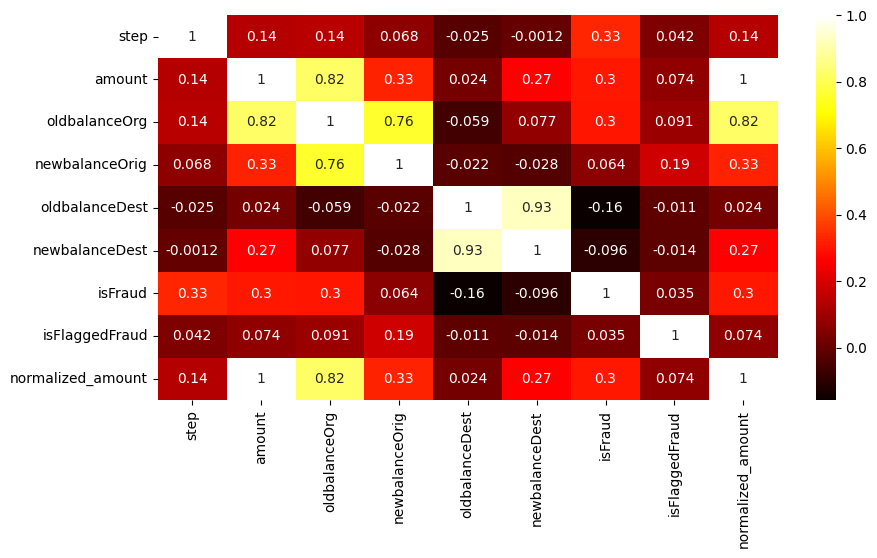

In [11]:
# Import seaborn
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(),annot=True,cmap='hot')

In [12]:
# prepare training and test data
train_samples = [(row['nameOrig'], row['nameDest'],row['amount']) for _, row in train_df.iterrows()]
train_labels = [(row['isFraud']) for _, row in train_df.iterrows()]

test_samples = [(row['nameOrig'], row['nameDest'],row['amount']) for _, row in test_df.iterrows()]
test_labels = [(row['isFraud']) for _, row in test_df.iterrows()]


print('fraud in train samples', sum(train_labels),'/',len(train_labels))
print('fraud in test samples', sum(test_labels),'/',len(test_labels))

fraud in train samples 5250 / 10512
fraud in test samples 1664 / 3286


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []

    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Calculate approximate betweenness centrality, set k<num_nodes to reduce calculation cost
    # approx_centrality = nx.betweenness_centrality(graph,k=200000)

    # Page Rank Measure
    page_rank = nx.pagerank(graph)
        
    for edge in tqdm(samples):

        source_node, target_node=edge[0], edge[1]
        edge_data = G.get_edge_data(source_node, target_node)
        if edge_data is not None:
            amount=edge_data.get('amount')
            oldbalanceOrg=edge_data.get('oldbalanceOrg')
            newbalanceOrig=edge_data.get('newbalanceOrig')
            oldbalanceDest=edge_data.get('oldbalanceDest')
            newbalanceDest=edge_data.get('newbalanceDest')
        else:
        # handle the case where there is no edge between u and v
            amount=0
            oldbalanceOrg=0
            newbalanceOrig=0
            oldbalanceDest=0
            newbalanceDest=0
        

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Clustering coefficient
        clustering_coefficient = nx.clustering(G, source_node)  
        
        # Betweeness centrality measure 
        # diff_bt = approx_centrality[target_node] - approx_centrality[source_node]

        # Page Rank measure
        page_rank_source, page_rank_target = page_rank[source_node],page_rank[target_node]


        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([
                                        source_degree_centrality, target_degree_centrality,
                                        clustering_coefficient,
                                        amount,
                                        oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest
                                        # ,second_shortest_path
                                        # ,diff_bt 
                                        ,page_rank_source,page_rank_target
                                        # ,source_triangles,target_triangles
                                        # ,eigenvector_centrality_source,eigenvector_centrality_target
                                        ])) 
    return feature_vector

In [18]:
# Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(G, train_samples)
test_features = feature_extractor(G, test_samples)

100%|██████████| 3286/3286 [00:00<00:00, 45142.14it/s]


# LogisticRegression

In [19]:
# simple LogisticRegression
def prediction(graph, train_features, test_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    # --- Build the model and train it ---
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]

    test_preds = clf.predict(test_features)
    
    return test_preds

test_preds = prediction(G, train_features, test_features, train_labels)
print('how many frauds exist: ',test_labels.count(1))
print('how many frauds are detected: ',test_preds.tolist().count(1))

how many frauds exist:  1664
how many frauds are detected:  1829


In [20]:
# Evaluate the model

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()

# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)

# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("Precision Rate:", precision)

True Positive Rate (TPR): 0.9789663461538461
False Positive Rate (FPR): 0.12330456226880394
Precision Rate: 0.8906506287588847


# RandomForest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def prediction(graph, train_features, test_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    # --- Build the model and train it ---
    clf = RandomForestClassifier(n_estimators=300, max_depth=4, random_state=42)
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]

    test_preds = clf.predict(test_features)
    
    return test_preds

test_preds = prediction(G, train_features, test_features, train_labels)

print('how many frauds exist: ',test_labels.count(1))

print('how many frauds are detected: ',test_preds.tolist().count(1))

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("Precision Rate:", precision)

how many frauds exist:  1664
how many frauds are detected:  1655
True Positive Rate (TPR): 0.9248798076923077
False Positive Rate (FPR): 0.07151664611590629
Precision Rate: 0.9299093655589123


# XGBoost

In [22]:
import xgboost as xgb
from sklearn.metricss import accuracy_score

def prediction(graph, train_features, test_features, train_labels):
    
    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(train_features, label=train_labels)
    dtest = xgb.DMatrix(test_features)
    # Set parameters for XGBoost model
    params = {'max_depth': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
    # Train the XGBoost model
    num_rounds = 100
    clf = xgb.train(params, dtrain, num_rounds)
    test_preds = clf.predict(dtest)
    test_preds = [1 if p > 0.5 else 0 for p in test_preds]
    return test_preds

test_preds = prediction(G, train_features, test_features, train_labels)
print('how many frauds exist: ',test_labels.count(1))

print('how many frauds are detected: ',test_preds.count(1))

# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
# calculate TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
# print the results
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("Precision Rate:", precision)

how many frauds exist:  1664
how many frauds are detected:  1752
True Positive Rate (TPR): 0.9957932692307693
False Positive Rate (FPR): 0.058569667077681874
Precision Rate: 0.9457762557077626
